In [1]:
#import os
#os.system ("pip install keras==2.4.3")

!pip install tensorflow

import keras
print('The keras version is {}.'.format(keras.__version__))

Defaulting to user installation because normal site-packages is not writeable


2025-02-27 04:22:52.289580: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 04:22:52.821859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-27 04:22:54.885580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB
VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB
The keras version is 2.13.1.


In [2]:
# IPython display functions
import IPython
from IPython.display import display, HTML, SVG, Image

# General Plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

## notebook style and settings
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))

# For changing background color
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

/tmp/ipykernel_4301/3485464767.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


Library Imports

In [3]:
import os
import sys
import random
import numpy as np
import pandas as pd
from os import walk

# Metrics
from sklearn.metrics import *

# Keras library for deep learning
# https://keras.io/
import tensorflow as tf
import keras
from keras.datasets import mnist # MNIST Data set
from keras.models import Sequential # Model building
from keras.layers import * # Model layers
from keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Helper Functions

## 1.1 Confusion Matrix
Confusion matrices are an important toolkit in every data scientist's box. We have created a function for you that you can use to create visual confusion matrices and analyze your models.

In [4]:
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    # Set font size for the plots. You can ignore this line.
    PLOT_FONT_SIZE = 14
    
    # Set plot size. Please ignore this line
    plt.rcParams['figure.figsize'] = [5, 5]
    
    # Transpose of confusion matrix to align the plot with the actual precision recall values. Please ignore this as well.
    confusionMatrix = np.transpose(confusionMatrix)
    
    # Plotting the confusion matrix
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    
    
    # Setting plot properties. You should ignore everything from here on.
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Healthy\nRecall=" + str(recallNegative) , "Pneumonia\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Healthy\nPrecision=" + str(precisionNegative) , "Pneumonia\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
        
    # Add text in heatmap boxes
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap
            
    plt.show()

In [5]:
def calculateMetrics(predictions, predictionsProbabilities, actualLabels):
    # Convert label format from [0,1](label 1) and [1,0](label 0) into single integers: 1 and 0.
    actualLabels = [item[1] for item in actualLabels]
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    try:
        accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
        precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
        precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
        recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
        recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    except:
        print("An exception occurred but was caught.")
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    
    return auc

## 1.2 Metrics Calculation
We are giving you a function that will calculate all the metrics you'll need in order to analyze your model

In [6]:
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    # Convert label format from [0,1](label 1) and [1,0](label 0) into single integers: 1 and 0.
    actualLabels = [item[1] for item in actualLabels]
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    
    # Print metrics. .%2f prints a number upto 2 decimal points only.
    print("------------------------------------------------------------------------")
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    print("------------------------------------------------------------------------")
    
    print("+ Printing confusion matrix...\n")
    # Display confusion matrix
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    
    print("+ Printing ROC curve...\n")
    # ROC Curve
    plt.rcParams['figure.figsize'] = [16, 8]
    FONT_SIZE = 16
    falsePositiveRateDt, truePositiveRateDt, _ = roc_curve(actualLabels, predictionsProbabilities)
    plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 5, color='black')
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
    plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
    plt.show()
    
    return auc

## 1.3 Kaggle Predictions

In [7]:
def getKagglePredictions(model, kaggleData, filename):
    print("+ Writing kaggle test results in : results/%s..." % filename)
    predictions = model.predict(kaggleData)
    predictionProbs = [item[1] for item in predictions]
        
    # Store predictions for kaggle
    outputFile = open("results/" + str(filename), "w")
    outputFile.write("Id,Prediction\n")
    for i in range(0, len(predictionProbs)):
        outputFile.write(str(i + 1) + "," + str(predictionProbs[i]) + "\n")
    
    outputFile.close()

## 1.4 Top n% accuracy

In [8]:
def calculateClasswiseTopNAccuracy(actualLabels, predictionsProbs, TOP_N):
    """
    TOP_N is the top n% predictions you want to use for each class
    """

    discreteActualLabels = [1 if item[1] > item[0] else 0 for item in actualLabels]
    discretePredictions = [1 if item[1] > item[0] else 0 for item in predictionsProbs]
    predictionProbsTopNHealthy, predictionProbsTopNPneumonia = [item[0] for item in predictionsProbs], [item[1] for item in predictionsProbs]
    predictionProbsTopNHealthy = list(reversed(sorted(predictionProbsTopNHealthy)))[:int(len(predictionProbsTopNHealthy) * TOP_N / 100)][-1]
    predictionProbsTopNPneumonia = list(reversed(sorted(predictionProbsTopNPneumonia)))[:int(len(predictionProbsTopNPneumonia) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyHealthy = []
    accuracyPneumonia = []
    for i in range(0, len(discretePredictions)):
        if discretePredictions[i] == 1:
            # Pneumonia
            if predictionsProbs[i][1] > predictionProbsTopNPneumonia:
                accuracyPneumonia.append(int(discreteActualLabels[i]) == 1)
        else:
            # Healthy
            if predictionsProbs[i][0] > predictionProbsTopNHealthy:
                accuracyHealthy.append(int(discreteActualLabels[i]) == 0)

    accuracyHealthy = round((accuracyHealthy.count(True) * 100) / len(accuracyHealthy), 2)
    accuracyPneumonia = round((accuracyPneumonia.count(True) * 100) / len(accuracyPneumonia), 2)
    return accuracyHealthy, accuracyPneumonia

# 2. Data Loading
## 2.1 Loading File Paths
We will first load file paths from normal and pneumonia folders in the train directory.

In [9]:
# Load normal images
normalImagesPath = "data/train/normal"
normalImageFiles = []
for(_,_,files) in walk(normalImagesPath):
    normalImageFiles.extend(files)

normalImagesPath2 = "data/train/normal2"
for(_,_,files) in walk(normalImagesPath2):
    normalImageFiles.extend(files)

print(len(normalImageFiles))

# Load pneumonia images
pneumoniaImagesPath = "data/train/pneumonia"
pneumoniaImageFiles = []
for(_,_,files) in walk(pneumoniaImagesPath):
    pneumoniaImageFiles.extend(files)
    
random.shuffle(pneumoniaImageFiles)
pneumoniaImageFiles = pneumoniaImageFiles[:len(normalImageFiles)]
print("Normal X-ray images: %d\nPneumonia X-ray images: %d" % (len(normalImageFiles), len(pneumoniaImageFiles)))

1436
Normal X-ray images: 1436
Pneumonia X-ray images: 1436


## 2.2 Loading Image Data
### 2.2.1 Training and Validation

In [10]:
imagesData = []
imagesLabels = []

for file in normalImageFiles:
    fullPath = normalImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
        fullPath = normalImagesPath2 + "/" + file
        if os.path.exists(fullPath) == False:
            continue
    imageData = load_img(fullPath, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(0)
    

for file in pneumoniaImageFiles:
    fullPath = pneumoniaImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
            continue
            
    imageData = load_img(pneumoniaImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(1)

imagesData = np.array(imagesData)
imagesLabels = keras.utils.to_categorical(imagesLabels)
print("Input data shape: %s" % (imagesData.shape,))

Input data shape: (2872, 256, 256, 1)


In [11]:
"""
from zipfile import ZipFile
file_name = "data/test.zip"

# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall("data/") 
    print('Done!')
"""

'\nfrom zipfile import ZipFile\nfile_name = "data/test.zip"\n\n# opening the zip file in READ mode \nwith ZipFile(file_name, \'r\') as zip: \n    # printing all the contents of the zip file \n    zip.printdir() \n  \n    # extracting all the files \n    print(\'Extracting all the files now...\') \n    zip.extractall("data/") \n    print(\'Done!\')\n'

### 2.2.2 Kaggle Testing Data

In [12]:
testImagesPath = "data/test/"
testImageFiles = []
for(_,_,files) in walk(testImagesPath):
    testImageFiles.extend(files)
testImageFiles = list(sorted(testImageFiles))
    
kaggleTestImages = []
for file in testImageFiles:
    fullPath = testImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
        continue
    imageData = load_img(testImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    kaggleTestImages.append(imageArray)
    
kaggleTestImages = np.array(kaggleTestImages)
print("Number of test images: %d" % len(kaggleTestImages))

Number of test images: 200


## 2.3 Data Splitting into Training and Validation

In [13]:
def trainTestSplit(data, labels):
    """
    80-20 train-test data split
    """
    trainData, trainLabels, testData, testLabels = [], [], [], []
    for i in range(0, len(data)):
        if i % 5 == 0:
            testData.append(data[i])
            testLabels.append(labels[i])
        else:
            trainData.append(data[i])
            trainLabels.append(labels[i])
            
    return np.array(trainData), np.array(testData), np.array(trainLabels), np.array(testLabels)

In [14]:
# In our context, since we have a private test data on kaggle, our test data here would actually mean validation data. We will use results on this validation(test) data to see how our model would perform on the actual test data.
# Split data into 80% training and 20% testing
trainData, testData, trainLabels, testLabels = trainTestSplit(imagesData, imagesLabels)

# 3. Deep Learning Models
We will use keras to create deep learning models. Since we are dealing with images, we will use convolutional layers. For more details, please visit: https://keras.io/layers/convolutional/


## 3.1 Parameterized Convolutional Neural Networks
We will first provide you with a simple function that takes in a few parameters and create a convolutional neural network model for you. This is the easiest way to create a CNN model.

In [15]:
from keras.metrics import AUC

def createParameterizedConvolutionalNeuralNetwork(trainImages, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses):
    # Create model object
    model = Sequential()
    
    # Add the first layer with dropout
    model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                     activation='relu', padding='same',
                     input_shape=trainImages.shape[1:]))
    model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
    model.add(Dropout(dropoutValue))
    
    while numLayers > 1:
        model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                         activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
        model.add(Dropout(dropoutValue))
        numLayers -= 1
    
    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropoutValue))
    model.add(Dense(numClasses, activation='softmax'))

    # ✅ Compile model with AUC metric
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate=learningRate),
                  metrics=['accuracy', AUC(name='auc')])

    return model


## 3.2 More Nuanced Convolutional Neural Networks
In this section, we provide you with a function where you can edit tiny details of the model to see if it can give you a greater lift as compared to the parameterized model.

In [16]:
from keras.layers import BatchNormalization

def createNuancedConvolutionalNeuralNetwork(trainImages, numClasses):
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=trainImages.shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))

    # Second Conv Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Third Conv Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Dense Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))

    # Compile with AUC Metric
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model




from keras.regularizers import l2
from keras.layers import BatchNormalization

def createOptimizedCNN(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))

    # Second Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Third Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with AUC as a metric
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model


# 4. Model Training
## 4.1 Data Augmentation
Deep learning models require huge amounts of data for good performance. Since we only have around 5k examples, we will use what's called "Data Augmentation" to create more data. To read more on data augmentation, please visit: https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9

In [17]:
set_background('#fce53a')

#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################

# You can change all these parameters for different results. Please go to the following links to read more about each parameter: 
# https://keras.io/preprocessing/image/
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
dataAugmentation = ImageDataGenerator(
    rotation_range=15,        # Slightly more rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,           # Slightly more aggressive zoom
    shear_range=0.15
)


## 4.2 Model Parameters

In [18]:
set_background('#fce53a')

#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################


numLayers = 3          # Number of convolutional layers
numFilters = 32        # Number of filters for the first conv layer
kernelSize = 3         # Size of the convolutional kernel
maxPooling = 2         # Pooling window size
dropoutValue = 0.3     # Dropout rate to prevent overfitting
learningRate = 0.0005  # Initial learning rate
numClasses = 2         # Binary classification (Healthy vs Pneumonia)
batchSize = 8        # Number of images per batch
epochs = 30

#####################################################################################################################################################


# Please do not change this line.
dataAugmentation.fit(trainData) # Training the augmentor in case we set USE_DATA_AUGMENTATION to True.

## 4.3 Training and Validation

### 4.3.1 Model Instantiation

In [19]:
# Create model
parameterizedModel = createParameterizedConvolutionalNeuralNetwork(trainData, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses=2)
print("+ Your parameterized model has been created...")

+ Your parameterized model has been created...


In [20]:
# You can create the other model with the following line
nonParameterizedModel = createNuancedConvolutionalNeuralNetwork(imagesData, numClasses = 2)
print("+ Your non parameterized model has been created...")

+ Your non parameterized model has been created...


In [21]:
#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################

# Please assign model the deep learning model you want to use i.e parameterizedModel or nonParameterizedModel
model = parameterizedModel

### 4.3.2 Model Training and Validation

+ Starting training. Each epoch can take about 2-5 minutes, hold tight!
-----------------------------------------------------------------------

Epoch 1/30
288/288 - 205s - loss: 2.4118 - accuracy: 0.7353 - auc: 0.7901 - val_loss: 142.2976 - val_accuracy: 0.5009 - val_auc: 0.5009 - lr: 1.0000e-04 - 205s/epoch - 710ms/step
Epoch 2/30
288/288 - 200s - loss: 0.8436 - accuracy: 0.8071 - auc: 0.8905 - val_loss: 126.7935 - val_accuracy: 0.5009 - val_auc: 0.5009 - lr: 1.0000e-04 - 200s/epoch - 693ms/step
Epoch 3/30
288/288 - 199s - loss: 0.7634 - accuracy: 0.8380 - auc: 0.9036 - val_loss: 1.7082 - val_accuracy: 0.7948 - val_auc: 0.8544 - lr: 1.0000e-04 - 199s/epoch - 692ms/step
Epoch 4/30
288/288 - 199s - loss: 0.6828 - accuracy: 0.8472 - auc: 0.9279 - val_loss: 6.4984 - val_accuracy: 0.7357 - val_auc: 0.7478 - lr: 1.0000e-04 - 199s/epoch - 691ms/step
Epoch 5/30
288/288 - 202s - loss: 0.6674 - accuracy: 0.8681 - auc: 0.9330 - val_loss: 28.9572 - val_accuracy: 0.5548 - val_auc: 0.5632 - lr: 1.

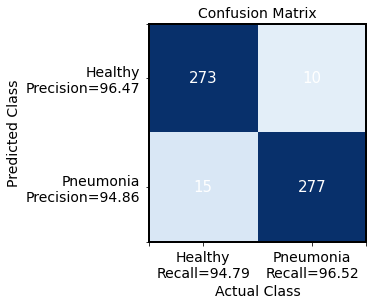

+ Printing ROC curve...



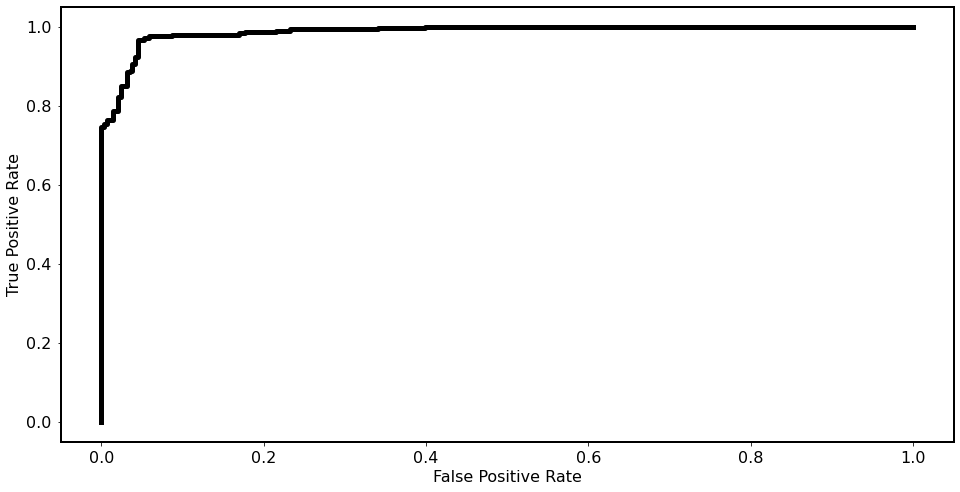

98.75

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=2,  # Stop after 2 stagnant epochs
    restore_best_weights=True,
    mode='max'
)


# Reduce learning rate when a metric has stopped improving
lr_reduce = ReduceLROnPlateau(
    monitor='val_auc',       # Monitor validation AUC
    factor=0.5,              # Reduce learning rate by half
    patience=3,              # Wait for 3 epochs before reducing LR
    min_lr=1e-7,             # Don't go below this learning rate
    mode='max'               # Because higher AUC is better
)

USE_DATA_AUGMENTATION = True  # or False, depending on whether you want to use it


bestAcc = 0.0
bestEpoch = 0
bestAccPredictions, bestAccPredictionProbabilities = [], []

print("+ Starting training. Each epoch can take about 2-5 minutes, hold tight!")
print("-----------------------------------------------------------------------\n")

# Define whether to use data augmentation
USE_DATA_AUGMENTATION = True  # Set to False if you want to disable it

optimizedModel = createOptimizedCNN(trainData.shape[1:], numClasses)

# Fit with callbacks
history = optimizedModel.fit(
    dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),
    validation_data=(testData, testLabels),
    epochs=30,  # Reduced for speed
    class_weight={0: 1, 1: 1.5},
    callbacks=[early_stop, lr_reduce],
    verbose=2
)

imageData = load_img(fullPath, color_mode="grayscale", target_size=(128, 128))


# Start Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    if USE_DATA_AUGMENTATION:
        # Use augmented data consistently for better generalization
        history = model.fit(
        dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),
        validation_data=(testData, testLabels),
        epochs=50,  # Allow more epochs, but early stopping will handle overfitting
        callbacks=[lr_reduce, early_stop],
        class_weight={0: 1, 1: 1.5},
        verbose=2)
    else:
        # Train without data augmentation
        history = model.fit(trainData, trainLabels,
                            batch_size=batchSize,
                            epochs=1,
                            validation_data=(testData, testLabels),
                            class_weight={0: 1, 1: 1.5},
                            verbose=2)

    
    #################################################### Model Testing ###############################################################
    # Evaluate on validation set
    accuracy = round(model.evaluate(testData, testLabels, verbose=0)[1] * 100, 3)
    predictions = model.predict(testData)
    AccPredictionProbabilities = predictions
    AccPredictions = [1 if item[1] > item[0] else 0 for item in AccPredictionProbabilities]
    epochAUC = calculateMetrics(AccPredictions, AccPredictionProbabilities, testLabels)

    print(f"+ Test accuracy at epoch {epoch + 1} is: {accuracy:.2f}")
    print(f"+ Test AUC at epoch {epoch + 1} is: {epochAUC:.3f}")

    # Logging results
    with open("results/Log.txt", "a") as outputFile:
        outputFile.write(f"Epoch-Accuracy-AUC \t {epoch + 1} \t {accuracy:.2f} \t {epochAUC:.3f} \n")
    
    # Save best model based on AUC
    if epochAUC > bestAcc:
        bestEpoch = epoch + 1
        bestAcc = epochAUC
        bestAccPredictions = AccPredictions
        bestAccPredictionProbabilities = AccPredictionProbabilities

        # Save predictions for Kaggle submission
        kaggleResultsFileName = f"epoch-{epoch + 1}-results.csv"
        getKagglePredictions(model, kaggleTestImages, kaggleResultsFileName)
        print(f"+ Saved Kaggle predictions to {kaggleResultsFileName}\n")
    
    print('\n' + '-'*72 + '\n')

print("------------------------------------------------------------------------")
print(f"*** Best AUC achieved: {bestAcc:.3f} at epoch {bestEpoch} ***")
print("------------------------------------------------------------------------")

##################################################### Printing Best Metrics ##########################################################
print(f"\n*** Printing our best validation results from epoch {bestEpoch} ...")
calculateMetricsAndPrint(bestAccPredictions, bestAccPredictionProbabilities, testLabels)


## 4.4 Top n% Predictions

+ Accuracy for top 5 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 10 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 20 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 30 percent predictions for healthy: 100.00, pneumonia: 100.00


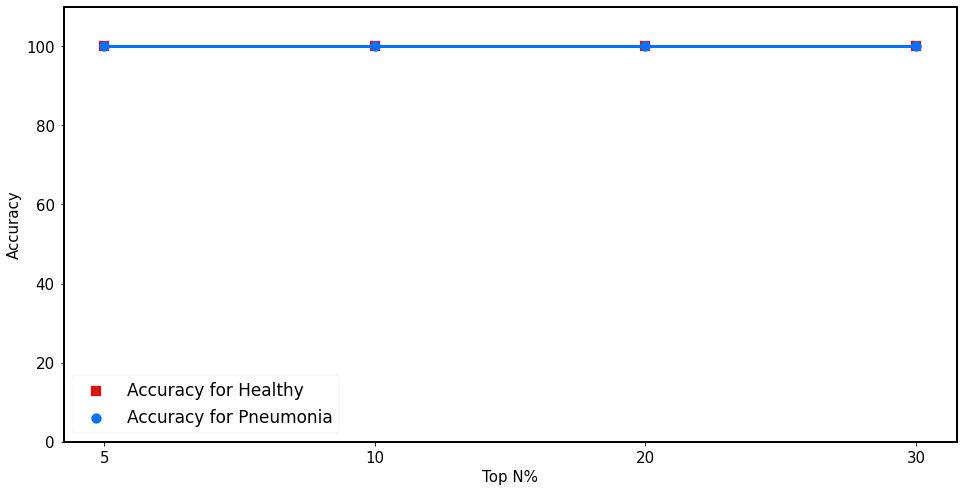

In [23]:
################################## You can change values inside the following list ###########################
topNValues = [5, 10, 20, 30]
##############################################################################################################

accuraciesHealthy, accuraciesPneumonia = [], []
for topn in topNValues:
    accuracyHealthy, accuracyPneumonia = calculateClasswiseTopNAccuracy(testLabels, bestAccPredictionProbabilities, topn)
    accuraciesHealthy.append(accuracyHealthy)
    accuraciesPneumonia.append(accuracyPneumonia)
    
    print("+ Accuracy for top %d percent predictions for healthy: %.2f, pneumonia: %.2f" % (topn, accuracyHealthy, accuracyPneumonia))
    
# Plot results
x = np.arange(len(accuraciesHealthy))
plt.plot(x, accuraciesHealthy, linewidth = 3, color = '#e01111')
scatterHealthy = plt.scatter(x, accuraciesHealthy, marker = 's', s = 100, color = '#e01111')
plt.plot(x, accuraciesPneumonia, linewidth = 3, color = '#0072ff')
scatterPneumonia = plt.scatter(x, accuraciesPneumonia, marker = 'o', s = 100, color = '#0072ff')
plt.xticks(x, topNValues, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Top N%", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend([scatterHealthy, scatterPneumonia], ["Accuracy for Healthy", "Accuracy for Pneumonia"], fontsize = 17)
plt.ylim(0, 110)
plt.show()


In [27]:
optimizedModel.save_weights("best_model_weights.h5")  # Saves only weights


In [28]:
# Rebuild the model architecture first
optimizedModel = createOptimizedCNN(trainData.shape[1:], numClasses)  

# Load the saved weights
optimizedModel.load_weights("best_model_weights.h5")  




In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Rebuild the model architecture first
optimizedModel = createOptimizedCNN(trainData.shape[1:], numClasses)  

# Load the saved weights
optimizedModel.load_weights("best_model_weights.h5")  

# Generate and save model visualization
plot_model(optimizedModel, to_file="model_architecture.png", show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96)

# Display the model image
img = plt.imread("model_architecture.png")
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.show()



2025-02-27 06:07:50.018149: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 06:07:50.595245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-27 06:07:52.597924: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB
VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB


NameError: name 'createOptimizedCNN' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2da7edf6-dcd9-4d26-8af1-b990b67baf63' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>